In [12]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer # To handle potential NaNs in 'likes'
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np # For handling sparse matrix if needed

In [13]:
# --- Configuration ---
file_path = r'D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\cleaned_taptap_reviews.csv'
# Feature columns - EXCLUDING 'rating' to avoid data leakage
text_col = 'review_content'
categorical_cols = ['game_name']
numerical_cols = ['likes']
feature_columns = [text_col] + categorical_cols + numerical_cols
target_column = 'sentiment'
test_size = 0.2
random_state = 42

In [14]:
# --- 1. Load Data ---
print(f"开始加载数据: {file_path}")
try:
    df = pd.read_csv(file_path)
    print(f"数据加载成功，总行数: {len(df)}")
    # Select only necessary columns + target
    df = df[feature_columns + [target_column]].copy()

    # Basic Missing Value Handling (Important before encoding/vectorizing)
    df[text_col] = df[text_col].fillna('') # Fill missing reviews with empty string
    df[categorical_cols] = df[categorical_cols].fillna('Unknown') # Fill missing categoricals
    # Keep NaNs in numerical for now, SimpleImputer will handle them later in the pipeline
    df.dropna(subset=[target_column], inplace=True) # Drop rows where target is missing
    print(f"\n处理必要列的缺失值后，剩余行数: {len(df)}")

    # Ensure target column is integer type
    df[target_column] = df[target_column].astype(int)

    print("\n数据信息 (选择的列):")
    df.info()
    print(f"\n目标变量 '{target_column}' 分布:")
    print(df[target_column].value_counts(normalize=True))

except FileNotFoundError:
    print(f"错误: 文件未找到 {file_path}")
    exit()
except Exception as e:
    print(f"加载或初步处理数据时发生错误: {e}")
    exit()

开始加载数据: D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\cleaned_taptap_reviews.csv
数据加载成功，总行数: 39985

处理必要列的缺失值后，剩余行数: 39985

数据信息 (选择的列):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39985 entries, 0 to 39984
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review_content  39985 non-null  object
 1   game_name       39985 non-null  object
 2   likes           39985 non-null  int64 
 3   sentiment       39985 non-null  int32 
dtypes: int32(1), int64(1), object(2)
memory usage: 1.1+ MB

目标变量 'sentiment' 分布:
sentiment
1    0.659072
0    0.340928
Name: proportion, dtype: float64


In [15]:
# --- 2. Prepare Features and Target ---
X = df[feature_columns]
y = df[target_column]

In [16]:
# --- 3. Split Data ---
print(f"\n划分数据集，测试集比例: {test_size}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y
)
print(f"训练集大小: {X_train.shape[0]}, 测试集大小: {X_test.shape[0]}")


划分数据集，测试集比例: 0.2
训练集大小: 31988, 测试集大小: 7997


In [17]:
# --- 4. Create Preprocessing Pipeline ---
print("\n创建预处理和模型管道...")

# Define preprocessing steps for different column types
# Text: TF-IDF Vectorizer
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words=None)) # Limit features for efficiency
    # Consider adding stop_words='english' or a custom list if needed
])

# Categorical: One-Hot Encoder
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # handle_unknown ignores categories present only in test set
])

# Numerical: Simple Imputer (e.g., fill with median)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
    # Optionally add StandardScaler here: ('scaler', StandardScaler())
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, text_col),
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ],
    remainder='passthrough' # Keep other columns (if any) - should be none here
)


创建预处理和模型管道...


In [18]:
# --- 5. Define XGBoost Classifier ---
print("初始化 XGBoost 分类器...")
# Determine objective based on number of classes
num_classes = len(y.unique())
if num_classes == 2:
    objective = 'binary:logistic'
    eval_metric = 'logloss' # Common metrics: 'logloss', 'auc', 'error'
    print("检测到二分类任务")
elif num_classes > 2:
    objective = 'multi:softmax' # Or 'multi:softprob' to get probabilities
    eval_metric = 'mlogloss' # Common metrics: 'mlogloss', 'merror'
    print(f"检测到 {num_classes} 分类任务")
else:
    print("错误：目标变量类别数少于2。")
    exit()


xgb_model = xgb.XGBClassifier(
    objective=objective,
    eval_metric=eval_metric,
    use_label_encoder=False, # Recommended to set False for newer XGBoost versions
    n_estimators=1200,       # Number of boosting rounds (trees)
    learning_rate=0.05,
    max_depth=10,            # Max depth of trees
    subsample=0.8,           # Fraction of samples used per tree
    colsample_bytree=0.8,    # Fraction of features used per tree
    random_state=random_state,
    early_stopping_rounds=50, # Stop if eval metric doesn't improve for 50 rounds
    # --- GPU Parameters ---
    tree_method='hist',      # Use 'hist' for GPU support (also fast on CPU)
    device='cuda'            # Specify 'cuda' to use the GPU
)

初始化 XGBoost 分类器...
检测到二分类任务


In [19]:
# --- 6. Create Full Pipeline (Preprocessor + Classifier) ---
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', xgb_model)])

In [20]:
# --- 7. Fit Preprocessor and Train Classifier Separately ---
print("\n开始手动预处理数据...")
start_preprocess_time = time.time()

# 7.1 Fit the preprocessor on the training data
pipeline.named_steps['preprocessor'].fit(X_train, y_train)

# 7.2 Transform both training and test data
X_train_processed = pipeline.named_steps['preprocessor'].transform(X_train)
X_test_processed = pipeline.named_steps['preprocessor'].transform(X_test)

end_preprocess_time = time.time()
print(f"数据预处理完成，耗时: {end_preprocess_time - start_preprocess_time:.2f} 秒")
print(f"处理后训练数据维度: {X_train_processed.shape}")
print(f"处理后测试数据维度: {X_test_processed.shape}")


print("\n开始训练 XGBoost 模型 (使用预处理后的数据进行早停)...")
start_train_time = time.time()

# 7.3 Train the classifier directly on the PROCESSED data
# Access the classifier instance from the pipeline to train it
# Note: We are fitting the classifier step directly here.
pipeline.named_steps['classifier'].fit(X_train_processed, y_train,
                                       eval_set=[(X_test_processed, y_test)], # Use PROCESSED test data for eval
                                       verbose=100) # Show progress every 100 rounds

end_train_time = time.time()
print(f"模型训练完成，耗时: {end_train_time - start_train_time:.2f} 秒")


开始手动预处理数据...
数据预处理完成，耗时: 0.91 秒
处理后训练数据维度: (31988, 5041)
处理后测试数据维度: (7997, 5041)

开始训练 XGBoost 模型 (使用预处理后的数据进行早停)...


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\xgboost\callback.py:386: UserWarning: [18:34:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-logloss:0.62968
[100]	validation_0-logloss:0.42260
[200]	validation_0-logloss:0.39940
[300]	validation_0-logloss:0.38918
[400]	validation_0-logloss:0.38363
[500]	validation_0-logloss:0.37975
[600]	validation_0-logloss:0.37734
[700]	validation_0-logloss:0.37561
[800]	validation_0-logloss:0.37493
[900]	validation_0-logloss:0.37384
[1000]	validation_0-logloss:0.37382
[1015]	validation_0-logloss:0.37368
模型训练完成，耗时: 20.39 秒


In [21]:
# --- 8. Predict on Test Set using the Full Pipeline ---
print("\n在测试集上进行预测 (使用完整管道)...")
# Now, calling pipeline.predict(X_test) works correctly because:
# 1. It uses the already fitted 'preprocessor' step to transform X_test internally.
# 2. It then uses the already fitted 'classifier' step (fitted in step 7.3) to predict.
y_pred = pipeline.predict(X_test)


在测试集上进行预测 (使用完整管道)...



模型评估:
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.69      0.73      2726
           1       0.85      0.90      0.87      5271

    accuracy                           0.83      7997
   macro avg       0.82      0.79      0.80      7997
weighted avg       0.83      0.83      0.83      7997


Confusion Matrix:
[[1879  847]
 [ 524 4747]]


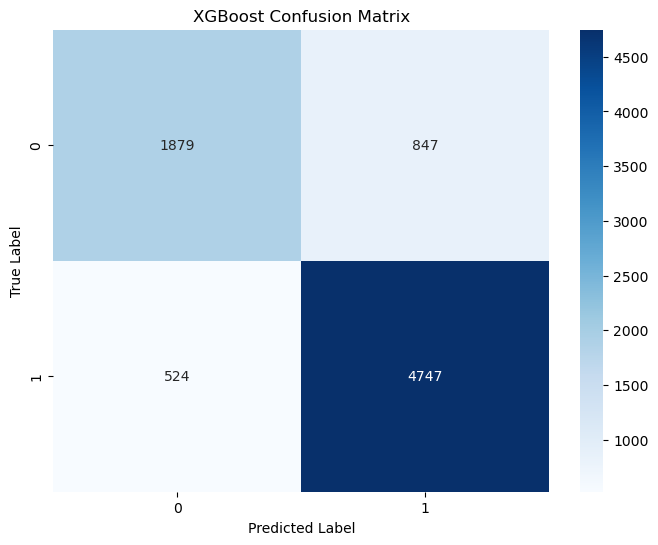


脚本执行完毕。


In [22]:
# --- 9. Evaluate Model ---
print("\n模型评估:")

# Classification Report
print("Classification Report:")
try:
    target_names = [str(c) for c in sorted(y.unique())]
    print(classification_report(y_test, y_pred, target_names=target_names))
except Exception as e:
    print(f"生成 classification report 时出错: {e}")
    print("Classification Report (无 target_names):")
    print(classification_report(y_test, y_pred))


# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix')
plt.show()

print("\n脚本执行完毕。")

In [23]:
# --- Save Probabilities for Ensemble ---
print("\n保存测试集预测概率 (XGBoost)...")
# Use the pipeline to predict probabilities on the original X_test
y_proba_xgb = pipeline.predict_proba(X_test)
np.save('predictions/probabilities_xgb.npy', y_proba_xgb)
print("XGBoost 概率已保存到 predictions/probabilities_xgb.npy")


保存测试集预测概率 (XGBoost)...
XGBoost 概率已保存到 predictions/probabilities_xgb.npy
